In [1]:
import openchord as ocd
import pandas as pd
import networkx as nx
import os
# go one up
os.chdir("..")

In [2]:
vos_links = pd.read_csv(f'data{os.sep}prepared{os.sep}vos_links.csv')
vos_links.head()

,VOS_Source_ID,VOS_Target_ID,Strength
0,2,3,2.0
1,2,4,5.0
2,2,7,1.0
3,2,8,4.0
4,2,9,5.0


In [3]:
vos_links.max()

VOS_Source_ID    2196.0
VOS_Target_ID    2506.0
Strength           91.0
dtype: float64

In [4]:
vos_meta = pd.read_csv(f'data{os.sep}prepared{os.sep}vos_meta.csv')
# Filter out all rows with a total link strength below 10
vos_meta.head()

,VOS_ID,Authors,Title,Year,Citations,Source,Cluster,Links,Total link strength,Norm. citations
0,2,['Nick Bostrom'],Existential Risk Prevention As Global Priority,2013,346.0,Global policy,6,218.0,399.0,10.9205
1,3,"['Shahar Avin', ' Bonnie Wintle', ' Julius Wei...",Classifying Global Catastrophic Risks,2018,67.0,Futures,6,164.0,228.0,4.8564
2,4,['Nick Bostrom'],Existential Risks: Analyzing Human Extinction ...,2002,151.0,[no source],6,42.0,60.0,3.2386
3,7,"['Simon Beard', ' Lauren Holt', ' Asaf Tzachor...",Assessing Climate Change’S Contribution To Glo...,2021,41.0,Futures,2,208.0,422.0,6.1970
4,8,"['Alexey Turchin', ' David Denkenberger']",Classification Of Global Catastrophic Risks Co...,2018,50.0,Ai & society,6,158.0,226.0,3.6242


In [5]:
vos_meta["Total link strength"].max()

878.0

In [6]:
# Merge via the 'VOS_ID' column
vos_source = pd.merge(vos_links, vos_meta, right_on='VOS_ID', left_on='VOS_Source_ID', how="right")
vos_source = vos_source[['VOS_Source_ID', 'VOS_Target_ID', "Strength", "Cluster"]]
vos_source.columns = ['Source', 'Target', 'Strength', 'Source Cluster']
vos_source.head()

,Source,Target,Strength,Source Cluster
0,2.0,3.0,2.0,6
1,2.0,4.0,5.0,6
2,2.0,7.0,1.0,6
3,2.0,8.0,4.0,6
4,2.0,9.0,5.0,6


In [7]:
# Merge again to get the target cluster
vos_target = pd.merge(vos_links, vos_meta, right_on='VOS_ID', left_on='VOS_Target_ID', how="right")
vos_target = vos_target[['VOS_Source_ID', 'VOS_Target_ID', "Strength", "Cluster"]]
vos_target.columns = ['Source', 'Target', 'Strength', 'Target Cluster']
vos_target.head()


,Source,Target,Strength,Target Cluster
0,NaN,NaN,NaN,6
1,2.0,3.0,2.0,6
2,2.0,4.0,5.0,6
3,2.0,7.0,1.0,2
4,3.0,7.0,3.0,2


In [8]:
#assert vos_target.shape[0] == vos_source.shape[0]
# Merge the two dataframes
vos = pd.merge(vos_source, vos_target, on=['Source', 'Target', 'Strength'])
vos.head()

,Source,Target,Strength,Source Cluster,Target Cluster
0,2.0,3.0,2.0,6,6
1,2.0,4.0,5.0,6,6
2,2.0,7.0,1.0,6,2
3,2.0,8.0,4.0,6,6
4,2.0,9.0,5.0,6,6


In [9]:
# Analyse how much strength is from one cluster to another
cluster_strength = vos[["Strength", "Source Cluster", "Target Cluster"]].groupby(['Source Cluster', 'Target Cluster']).sum()
cluster_strength

Strength
Source Cluster Target Cluster          
1              1                 3907.0
               2                  170.0
               3                  347.0
               4                  233.0
               5                  564.0
...                                 ...
9              5                  243.0
               6                  420.0
               7                  439.0
               8                   38.0
               9                 1249.0

[81 rows x 1 columns]

In [10]:
# Create a graph from the cluster strength
G = nx.DiGraph()
for index, row in cluster_strength.iterrows():
    # Skip self loops
    if index[0] == index[1]:
        continue
    G.add_edge(index[0], index[1], weight=row['Strength'])

In [11]:
# Get an adjacency matrix
adjacency_matrix = nx.to_pandas_adjacency(G)
adjacency_matrix

,1,2,3,4,5,6,7,8,9
1,0.0,170.0,347.0,233.0,564.0,652.0,458.0,99.0,200.0
2,288.0,0.0,450.0,266.0,372.0,392.0,445.0,136.0,301.0
3,349.0,256.0,0.0,115.0,203.0,131.0,151.0,64.0,94.0
4,333.0,236.0,226.0,0.0,233.0,262.0,240.0,84.0,138.0
5,747.0,313.0,216.0,113.0,0.0,371.0,239.0,152.0,184.0
6,1837.0,561.0,599.0,418.0,792.0,0.0,1259.0,137.0,982.0
7,828.0,381.0,471.0,230.0,453.0,897.0,0.0,96.0,583.0
8,156.0,86.0,70.0,76.0,296.0,88.0,64.0,0.0,20.0
9,424.0,211.0,228.0,111.0,243.0,420.0,439.0,38.0,0.0


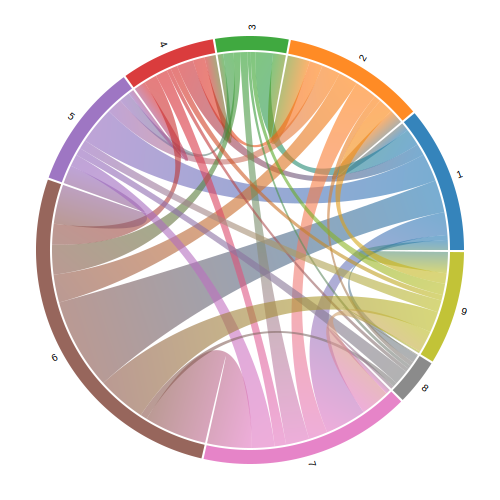

In [12]:
fig = ocd.Chord(adjacency_matrix, [str(i) for i in adjacency_matrix.columns])
# Get the colors from tab10
fig.colormap = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
fig.show()